⽹络中的⽹络（NiN）。它提出了另外⼀个思路，即串联多个由卷积层和“全连接”层构成的⼩⽹络来构建⼀个深层⽹络

# NIN块

我们知道，卷积层的输⼊和输出通常是四维数组（样本，通道，⾼，宽），⽽全连接层的输⼊和输出则通常是⼆维数组（样本，特征）。如果想在全连接层后再接上卷积层，则需要将全连接层的输出变换为四维。回忆在5.3节（多输⼊通道和多输出通道）⾥介绍的 1x1卷积层。它可以看成全连接层，其中空间维度（⾼和宽）上的每个元素相当于样本，通道相当于特征。因此，NiN使⽤ 卷积层来替代全连接层，从⽽使空间信息能够⾃然传递到后⾯的层中去。

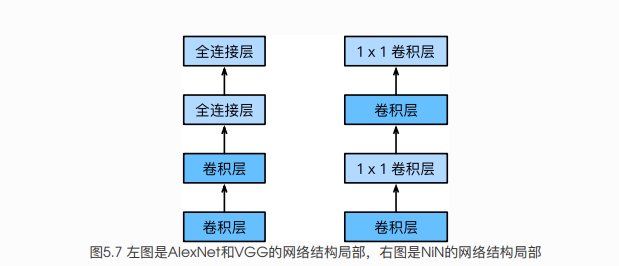

NiN块是NiN中的基础块。它由⼀个卷积层加两个充当全连接层的 卷积层串联⽽成。其中第⼀个卷积层的超参数可以⾃⾏设置，⽽第⼆和第三个卷积层的超参数⼀般是固定的

In [16]:
import time
import torch
from torch import nn,optim
import torch.nn.functional as F

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def nin_block(in_channels,out_channels,kernel_size,stride,padding):
    blk=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=1),
        nn.ReLU()
    )
    return blk

# NIN模型

NiN是在AlexNet问世不久后提出的。它们的卷积层设定有类似之处。NiN使⽤卷积窗⼝形状分别为11x11、5x5 和3x3 的卷积层，相应的输出通道数也与AlexNet中的⼀致。每个NiN块后接⼀个步幅为2、窗⼝形状为3x3 的最⼤池化层。除使⽤NiN块以外，NiN还有⼀个设计与AlexNet显著不同：NiN去掉了AlexNet最后的3个全连接层，取⽽代之地，NiN使⽤了输出通道数等于标签类别数的NiN块，然后使⽤全局平均池化层对每个通道中所有元素求平均并直接⽤于分类。这⾥的全局平均池化层即窗⼝形状等于输⼊空间维形状的平均池化层。NiN的这个设计的好处是可以显著减⼩模型参数尺⼨，从⽽缓解过拟合。然⽽，该设计有时会造成获得有效模型的训练时间的增加。

In [6]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer,self).__init__()
    def forward(self,x):
        return x.view(x.shape[0],-1)

In [1]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d,self).__init__()
    def forward(self,x):
        return F.avg_pool2d(x,kernel_size=x.size()[2:])

NameError: name 'nn' is not defined

In [17]:
net=nn.Sequential(
    nin_block(1,96,kernel_size=11,stride=4,padding=0),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nin_block(96,256,kernel_size=5,stride=1,padding=2),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nin_block(256,384,kernel_size=3,stride=1,padding=1),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Dropout(0.5),
    nin_block(384,10,kernel_size=3,stride=1,padding=1),
    GlobalAvgPool2d(),
    FlattenLayer()
)

In [18]:
X=torch.rand(1,1,224,224)
for name,blk in net.named_children():
    X=blk(X)
    print(name,'output shape:',X.shape)

0 output shape: torch.Size([1, 96, 54, 54])
1 output shape: torch.Size([1, 96, 26, 26])
2 output shape: torch.Size([1, 256, 26, 26])
3 output shape: torch.Size([1, 256, 12, 12])
4 output shape: torch.Size([1, 384, 12, 12])
5 output shape: torch.Size([1, 384, 5, 5])
6 output shape: torch.Size([1, 384, 5, 5])
7 output shape: torch.Size([1, 10, 5, 5])
8 output shape: torch.Size([1, 10, 1, 1])
9 output shape: torch.Size([1, 10])


# 获取数据和训练模型

In [19]:
import torchvision
import torchvision.transforms as transforms
def load_data_fashion_mnist(batch_size,resize=None,root='./Datasets/FashionMNIST'):
    trans=[]
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform=torchvision.transforms.Compose(trans)
    mnist_train=torchvision.datasets.FashionMNIST(root=root,train=True,download=True,transform=transform)
    mnist_test=torchvision.datasets.FashionMNIST(root=root,train=False,download=True,transform=transform)
    train_iter=torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=0)
    test_iter=torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=0)
    return train_iter,test_iter

batch_size=64
train_iter,test_iter=load_data_fashion_mnist(batch_size,resize=224)
lr,num_epochs=0.002,5
optimizer=torch.optim.Adam(net.parameters(),lr=lr)

In [20]:
def evaluate_accuracy(data_iter,net,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    acc_sum,n=0.0,0
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(net,torch.nn.Module):
                net.eval()#评估模式，这会关闭dropout
                acc_sum+=(net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().cpu().item()
                net.train()#改回训练模式
            else:
                if('is_training' in net.__code__.co_varname):
                    acc_sum+=(net(X,is_training=False).argmax(dim=1)==y).float().sum().item()
            n+=y.shape[0]
    return acc_sum/n

In [21]:
def train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs):
    net=net.to(device)
    print('training on ',device)
    loss=torch.nn.CrossEntropyLoss()
    batch_count=0
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n,start=0.0,0.0,0,time.time()
        for X,y in train_iter:
            X=X.to(device)
            y=y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.cpu().item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().cpu().item()
            n+=y.shape[0]
            batch_count+=1
        test_acc=evaluate_accuracy(test_iter,net)
        print('epoch %d,loss %.4f,train acc %.3f,test acc %.3f,time %.lf sec'%(epoch+1,train_l_sum/batch_count,train_acc_sum/n,test_acc,time.time()-start))

In [22]:
train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

training on  cuda


KeyboardInterrupt: 